# Country Codes in Datasets

We have multiple data sources which contains different sets of country codes.

In this notebook, we will analyse the country codes from different data sources and the ones that are supported by Tableau.

At the end of this notebook, we produce some CSV files.

## Table of Contents:

* [Country Code Analysis](#Country-Code-Analysis)
    * [Tableau Supported Map Data](#Tableau-Supported-Map-Data)
    * [World Bank Climate Data](#World-Bank-Climate-Data)
    * [Scrapped World Bank Temperature Data](#Scrapped-World-Bank-Temperature-Data)
    * [Intersecting the Country Codes](#Intersecting-the-Country-Codes)
* [Combining the Scrapped Data](#Combining-the-Scrapped-Data)
    * [Concatenating All Temperature Data](#Concatenating-All-Temperature-Data)*
    * [Concatenating Temperature Data of Available Country Codes](#Concatenating-Temperature-Data-of-Available-Country-Codes)*
* [Merging Imputed Data and Temperature Data](#Merging-Imputed-Data-and-Temperature-Data)   
    * [Understanding the Datasets](#Understanding-the-Datasets)
    * [Merging the Datasets](#Merging-the-Datasets)
 
\* produces CSV notebooks. All outputs are in `output\`

List of CSV produced in chronological order:

1. `temperature_all.csv`: All scrapped temperature data concatenated together
2. `temperature_filtered.csv`: Only scrapped temperature data with intersected country codes are concatenated
3. `WorldBank_Climate_Data.csv`: World Bank complete climate change and temperature data 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_circles # need pip install matplotlib_venn
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import math
import os
import missingno as msno
from bs4 import BeautifulSoup
import requests
from tqdm.notebook import tqdm # (optional) to look cool when waiting for for loops 🙈 

import warnings
warnings.filterwarnings("ignore")

## Country Code Analysis

### Tableau Supported Map Data

[About Tableau Maps](https://www.tableau.com/mapdata?_ga=2.28389562.701025511.1644926306-701361297.1641624970#data)

In [2]:
url = "https://www.tableau.com/mapdata?_ga=2.28389562.701025511.1644926306-701361297.1641624970#data"

html_content = requests.get(url).text
soup = BeautifulSoup(html_content, "lxml")

In [3]:
main_content = soup.find("div", attrs={"id": "main_content"})
h5_contents = main_content.find_all("h5")

In [4]:
supported_country_names = {} 
supported_country_codes = []

for h5 in h5_contents:
    country_name_and_code = h5.contents[0]
    
    country_name = country_name_and_code[:-6]
    country_code = country_name_and_code[-4:-1]
    
    supported_country_names[country_code] = country_name
    supported_country_codes.append(country_code)

In [5]:
print(len(supported_country_codes), "Tableau supported country codes")
print(supported_country_codes)

250 Tableau supported country codes
['AFG', 'ALB', 'DZA', 'ASM', 'AND', 'AGO', 'AIA', 'ATA', 'ATG', 'ARG', 'ARM', 'ABW', 'AUS', 'AUT', 'AZE', 'BHR', 'BGD', 'BRB', 'BLR', 'BEL', 'BLZ', 'BEN', 'BMU', 'BTN', 'BOL', 'BES', 'BIH', 'BWA', 'BVT', 'BRA', 'IOT', 'VGB', 'BRN', 'BGR', 'BFA', 'BDI', 'KHM', 'CMR', 'CAN', 'CPV', 'CYM', 'CAF', 'TCD', 'CHL', 'CHN', 'CXR', 'CCK', 'COL', 'COM', 'COG', 'COK', 'CRI', 'HRV', 'CUB', 'CUW', 'CYP', 'CZE', 'CIV', 'COD', 'DNK', 'DJI', 'DMA', 'DOM', 'ECU', 'EGY', 'SLV', 'GNQ', 'ERI', 'EST', 'SWZ', 'ETH', 'FLK', 'FRO', 'FSM', 'FJI', 'FIN', 'FRA', 'GUF', 'PYF', 'ATF', 'GAB', 'GMB', 'GEO', 'DEU', 'GHA', 'GIB', 'GRC', 'GRL', 'GRD', 'GLP', 'GUM', 'GTM', 'GGY', 'GIN', 'GNB', 'GUY', 'HTI', 'HMD', 'HND', 'HKG', 'HUN', 'ISL', 'IND', 'IDN', 'IRN', 'IRQ', 'IRL', 'IMN', 'ISR', 'ITA', 'JAM', 'JPN', 'JEY', 'JOR', 'KAZ', 'KEN', 'KIR', 'KOS', 'KWT', 'KGZ', 'LAO', 'LVA', 'LBN', 'LSO', 'LBR', 'LBY', 'LIE', 'LTU', 'LUX', 'MAC', 'MDG', 'MWI', 'MYS', 'MDV', 'MLI', 'MLT', 'MHL', 'MTQ

### World Bank Climate Data

In [6]:
# worldbank imputed data
df_worldbank = pd.read_csv('output/worldbank_imputed.csv')

# worldbank country codebook
meta_country = pd.read_csv('dataset/worldbank/Metadata_Country_API_19_DS2_en_csv_v2_3159902.csv')

worldbank_country_codes = []
worldbank_country_names = df_worldbank['Country Name'].unique().tolist()

for country in worldbank_country_names:
    try:
        code = meta_country.loc[meta_country['TableName'] == country].iloc[0]['Country Code']
        worldbank_country_codes.append(code)
    except IndexError:
        print(country)

Cote d'Ivoire
Sao Tome and Principe
East Asia & Pacific (IDA & IBRD countries)
Europe & Central Asia (IDA & IBRD countries)
Latin America & the Caribbean (IDA & IBRD countries)
Middle East & North Africa (IDA & IBRD countries)
Sub-Saharan Africa (IDA & IBRD countries)


Cote d'Ivoire (CIV) and Sao Tome and Principe (STP) are spelled differently in Worldbank data and its codebook.

| Worldbank data        | Codebook              |
| --------------------- | --------------------- |
| Cote d'Ivoire         | Côte d'Ivoire         |
| Sao Tome and Principe | São Tomé and Principe |



In [7]:
display(meta_country.loc[meta_country['Country Code'] == 'CIV'])
display(meta_country.loc[meta_country['Country Code'] == 'STP'])

,Country Code,Region,IncomeGroup,SpecialNotes,TableName,Unnamed: 5
41,CIV,Sub-Saharan Africa,Lower middle income,NaN,Côte d'Ivoire,NaN


,Country Code,Region,IncomeGroup,SpecialNotes,TableName,Unnamed: 5
218,STP,Sub-Saharan Africa,Lower middle income,National account data were adjusted to reflect...,São Tomé and Principe,NaN


Therefore we add `CIV` and `STP` into the list.

In [8]:
worldbank_country_codes.append('CIV')
worldbank_country_codes.append('STP')

In [9]:
print(len(worldbank_country_codes), "country codes")
print(worldbank_country_codes)

250 country codes
['ABW', 'AFE', 'AFG', 'AFW', 'AGO', 'ALB', 'AND', 'ARB', 'ARE', 'ARG', 'ARM', 'ASM', 'ATG', 'AUS', 'AUT', 'AZE', 'BDI', 'BEL', 'BEN', 'BFA', 'BGD', 'BGR', 'BHR', 'BHS', 'BIH', 'BLR', 'BLZ', 'BMU', 'BOL', 'BRA', 'BRB', 'BRN', 'BTN', 'BWA', 'CAF', 'CAN', 'CEB', 'CHE', 'CHL', 'CHN', 'CMR', 'COD', 'COG', 'COL', 'COM', 'CPV', 'CRI', 'CSS', 'CUB', 'CYM', 'CYP', 'CZE', 'DEU', 'DJI', 'DMA', 'DNK', 'DOM', 'DZA', 'EAP', 'EAR', 'EAS', 'ECA', 'ECS', 'ECU', 'EGY', 'EMU', 'ERI', 'ESP', 'EST', 'ETH', 'EUU', 'FCS', 'FIN', 'FJI', 'FRA', 'FRO', 'FSM', 'GAB', 'GBR', 'GEO', 'GHA', 'GIB', 'GIN', 'GMB', 'GNB', 'GNQ', 'GRC', 'GRD', 'GRL', 'GTM', 'GUM', 'GUY', 'HIC', 'HKG', 'HND', 'HPC', 'HRV', 'HTI', 'HUN', 'IBD', 'IBT', 'IDA', 'IDB', 'IDN', 'IDX', 'IND', 'IRL', 'IRN', 'IRQ', 'ISL', 'ISR', 'ITA', 'JAM', 'JOR', 'JPN', 'KAZ', 'KEN', 'KGZ', 'KHM', 'KIR', 'KNA', 'KOR', 'KWT', 'LAC', 'LAO', 'LBN', 'LBR', 'LBY', 'LCA', 'LCN', 'LDC', 'LIC', 'LIE', 'LKA', 'LMC', 'LMY', 'LSO', 'LTE', 'LTU', 'LUX', '

### Scrapped World Bank Temperature Data 

In [10]:
path = "dataset/data_scraping/data/"
data_list = os.listdir(path)
data_list

['tas_timeseries_annual_cru_1901-2020_ABW.csv',
 'tas_timeseries_annual_cru_1901-2020_AFG.csv',
 'tas_timeseries_annual_cru_1901-2020_AGO.csv',
 'tas_timeseries_annual_cru_1901-2020_AIA.csv',
 'tas_timeseries_annual_cru_1901-2020_ALB.csv',
 'tas_timeseries_annual_cru_1901-2020_AND.csv',
 'tas_timeseries_annual_cru_1901-2020_ARE.csv',
 'tas_timeseries_annual_cru_1901-2020_ARG.csv',
 'tas_timeseries_annual_cru_1901-2020_ARM.csv',
 'tas_timeseries_annual_cru_1901-2020_ASM.csv',
 'tas_timeseries_annual_cru_1901-2020_ATG.csv',
 'tas_timeseries_annual_cru_1901-2020_AUS.csv',
 'tas_timeseries_annual_cru_1901-2020_AUT.csv',
 'tas_timeseries_annual_cru_1901-2020_AZE.csv',
 'tas_timeseries_annual_cru_1901-2020_BDI.csv',
 'tas_timeseries_annual_cru_1901-2020_BEL.csv',
 'tas_timeseries_annual_cru_1901-2020_BEN.csv',
 'tas_timeseries_annual_cru_1901-2020_BFA.csv',
 'tas_timeseries_annual_cru_1901-2020_BGD.csv',
 'tas_timeseries_annual_cru_1901-2020_BGR.csv',
 'tas_timeseries_annual_cru_1901-2020_BH

In [11]:
len(data_list)

228

In [12]:
scrapped_country_codes = [filename[-7:-4] for filename in data_list]
print(len(scrapped_country_codes), "country codes")
print(scrapped_country_codes)

228 country codes
['ABW', 'AFG', 'AGO', 'AIA', 'ALB', 'AND', 'ARE', 'ARG', 'ARM', 'ASM', 'ATG', 'AUS', 'AUT', 'AZE', 'BDI', 'BEL', 'BEN', 'BFA', 'BGD', 'BGR', 'BHR', 'BHS', 'BIH', 'BLR', 'BLZ', 'BMU', 'BOL', 'BRA', 'BRB', 'BTN', 'BWA', 'CAF', 'CAN', 'CCK', 'CHE', 'CHL', 'CHN', 'CIV', 'CMR', 'COD', 'COG', 'COK', 'COL', 'COM', 'CPV', 'CRI', 'CUB', 'CXR', 'CYM', 'CYP', 'CZE', 'DEU', 'DJI', 'DMA', 'DNK', 'DOM', 'DZA', 'ECU', 'EGY', 'ERI', 'ESH', 'ESP', 'EST', 'ETH', 'FIN', 'FJI', 'FLK', 'FRA', 'FRO', 'FSM', 'GAB', 'GBR', 'GEO', 'GHA', 'GIB', 'GIN', 'GLP', 'GMB', 'GNB', 'GNQ', 'GRC', 'GRD', 'GRL', 'GTM', 'GUF', 'GUM', 'GUY', 'HND', 'HRV', 'HTI', 'HUN', 'IDN', 'IND', 'IOT', 'IRL', 'IRN', 'IRQ', 'ISL', 'ISR', 'ITA', 'JAM', 'JOR', 'JPN', 'KAZ', 'KEN', 'KGZ', 'KHM', 'KIR', 'KNA', 'KOR', 'KWT', 'LAO', 'LBN', 'LBR', 'LBY', 'LCA', 'LIE', 'LKA', 'LSO', 'LTU', 'LUX', 'LVA', 'MAC', 'MAR', 'MCO', 'MDA', 'MDG', 'MDV', 'MEX', 'MHL', 'MKD', 'MLI', 'MLT', 'MMR', 'MNE', 'MNG', 'MNP', 'MOZ', 'MRT', 'MSR', '

### Intersecting the Country Codes

Now we have 3 lists of country codes:

* `supported_country_codes`: List of country codes supported by Tableau
* `worldbank_country_codes`: List of country codes from our imputed World Bank climate data
* `scrapped_country_codes`: List of country codes from our scrapped World Bank temperature data

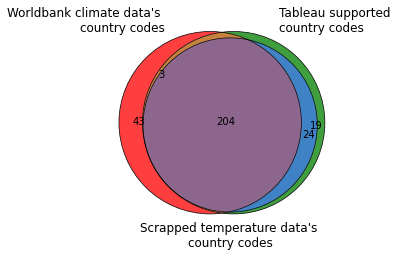

In [13]:
v = venn3([set(worldbank_country_codes), set(supported_country_codes), set(scrapped_country_codes)],
     set_labels = ("Worldbank climate data's \ncountry codes", 
                   "Tableau supported \ncountry codes",
                   "Scrapped temperature data's \ncountry codes"),
     alpha = 0.75)

# adds outter line
venn3_circles([set(worldbank_country_codes), set(supported_country_codes), set(scrapped_country_codes)], lw=0.7)

plt.show()

In [14]:
# intersecting the three lists
available_country_codes = list(set(worldbank_country_codes) & set(supported_country_codes) & set(scrapped_country_codes))
print(len(available_country_codes), "available country codes")
print(available_country_codes)

204 available country codes
['LBN', 'NOR', 'GIB', 'AUS', 'NER', 'GNQ', 'RWA', 'AFG', 'CYM', 'DNK', 'DJI', 'THA', 'CUB', 'PRI', 'MUS', 'SGP', 'NZL', 'BOL', 'KHM', 'CHE', 'COD', 'MYS', 'TJK', 'LTU', 'MAR', 'PSE', 'BIH', 'KNA', 'KIR', 'TCD', 'FSM', 'ROU', 'GUY', 'HTI', 'GNB', 'TLS', 'BRA', 'PRY', 'ETH', 'ESP', 'ZMB', 'NAM', 'MLI', 'AND', 'PRT', 'TCA', 'BFA', 'AUT', 'COL', 'ITA', 'GMB', 'BRB', 'SDN', 'IRN', 'MNG', 'STP', 'BDI', 'TTO', 'IDN', 'OMN', 'MOZ', 'PER', 'LCA', 'ZAF', 'TUV', 'ERI', 'ARE', 'MAC', 'CYP', 'BWA', 'BHS', 'MRT', 'BLZ', 'POL', 'JPN', 'LKA', 'GRL', 'MDG', 'VUT', 'RUS', 'BEN', 'LVA', 'ISR', 'GIN', 'PLW', 'VCT', 'ABW', 'TKM', 'LIE', 'JOR', 'COG', 'GHA', 'DMA', 'AZE', 'SWZ', 'KWT', 'NLD', 'ARG', 'LBR', 'SLB', 'UGA', 'HRV', 'TZA', 'COM', 'ATG', 'GRC', 'ASM', 'MHL', 'FRO', 'YEM', 'EGY', 'CRI', 'TGO', 'TUR', 'KAZ', 'PHL', 'LUX', 'NGA', 'SLE', 'MDA', 'VEN', 'MEX', 'MKD', 'BHR', 'KEN', 'NPL', 'MLT', 'GBR', 'VNM', 'BMU', 'BLR', 'TON', 'BGR', 'ISL', 'MNE', 'CAF', 'SAU', 'SOM', 'CAN'

## Combining the Scrapped Data

Combine scrapped temperature data together (all or some)

Let's have a look again on our scrapped data.

In [15]:
temp_df = pd.read_csv(path + 'tas_timeseries_annual_cru_1901-2020_MYS.csv', skiprows=1)
temp_df

,Unnamed: 0,Malaysia,Johor,Kedah,Kelantan,Kuala Lumpur,Melaka,Negeri Sembilan,Pahang,Perak,Perlis,Pulau Pinang,Sabah,Sarawak,Selangor,Terengganu,Labuan
0,1901,25.13,26.12,26.45,24.59,25.05,26.35,25.81,25.12,25.01,27.49,26.95,24.91,24.97,25.85,25.34,27.12
1,1902,25.12,26.11,26.46,24.59,25.05,26.33,25.81,25.12,25.01,27.49,26.96,24.90,24.96,25.85,25.34,27.12
2,1903,25.07,26.11,26.38,24.54,25.05,26.33,25.81,25.12,24.98,27.39,26.90,24.72,24.96,25.85,25.31,27.05
3,1904,25.01,26.12,26.28,24.49,25.05,26.34,25.80,25.10,24.94,27.25,26.84,24.46,24.96,25.84,25.28,26.95
4,1905,25.10,26.14,26.73,24.79,25.05,26.36,25.81,25.15,25.15,27.78,27.14,24.61,24.97,25.85,25.46,27.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,2016,26.30,27.56,27.65,25.90,26.43,27.76,27.19,26.48,26.33,28.56,28.19,25.94,26.04,27.21,26.66,28.18
116,2017,25.85,27.11,27.16,25.41,25.93,27.27,26.69,25.98,25.83,28.09,27.71,25.48,25.65,26.71,26.16,27.73
117,2018,25.89,27.15,27.18,25.42,25.95,27.32,26.73,26.02,25.84,28.09,27.73,25.57,25.68,26.74,26.20,27.80
118,2019,26.17,27.55,27.58,25.81,26.38,27.73,27.15,26.43,26.26,28.50,28.13,25.69,25.91,27.16,26.58,27.98


The normal csv file contains 120 rows (years, from 1901 to 2020). The columns should be the country itself, then the cities.

Let's double check if every csv file follows this format.

In [16]:
special_cases_df_list = []

# iterate the list of csv files name
for csv_file in data_list: 
    
    # skip first row as MOST files have unnecesary first row
    df = pd.read_csv(path + csv_file, skiprows=1)
    if len(df) != 120:
        print(f"{csv_file[-7:-4]}: {len(df)} rows")
        display(df.head(5))
        
        special_cases_df_list.append(csv_file)

special_cases_df_list

ESH: 119 rows


,1901,23.46
0,1902,23.45
1,1903,23.20
2,1904,23.11
3,1905,23.24
4,1906,23.25


FLK: 119 rows


,1901,6.38
0,1902,6.07
1,1903,6.10
2,1904,6.25
3,1905,5.74
4,1906,5.69


GLP: 119 rows


,1901,25.83
0,1902,25.49
1,1903,25.59
2,1904,25.18
3,1905,25.46
4,1906,25.32


GUF: 119 rows


,1901,26.11
0,1902,26.17
1,1903,26.15
2,1904,25.74
3,1905,25.95
4,1906,25.74


MTQ: 119 rows


,1901,25.23
0,1902,24.98
1,1903,25.05
2,1904,24.72
3,1905,24.93
4,1906,24.86


MYT: 119 rows


,1901,26.41
0,1902,26.66
1,1903,26.48
2,1904,26.43
3,1905,26.51
4,1906,26.46


REU: 119 rows


,1901,20.25
0,1902,20.38
1,1903,20.26
2,1904,20.26
3,1905,20.29
4,1906,20.30


['tas_timeseries_annual_cru_1901-2020_ESH.csv',
 'tas_timeseries_annual_cru_1901-2020_FLK.csv',
 'tas_timeseries_annual_cru_1901-2020_GLP.csv',
 'tas_timeseries_annual_cru_1901-2020_GUF.csv',
 'tas_timeseries_annual_cru_1901-2020_MTQ.csv',
 'tas_timeseries_annual_cru_1901-2020_MYT.csv',
 'tas_timeseries_annual_cru_1901-2020_REU.csv']

ESH, FLK, GLP, GUF, MTQ, MYT, REU are special cases. 

In [17]:
for csv_file in special_cases_df_list: 
    df = pd.read_csv(path + csv_file)
    print(f"{csv_file[-7:-4]}: {len(df)} rows")
    display(df.head())

ESH: 120 rows


,Variable:,tas
0,1901,23.46
1,1902,23.45
2,1903,23.20
3,1904,23.11
4,1905,23.24


FLK: 120 rows


,Variable:,tas
0,1901,6.38
1,1902,6.07
2,1903,6.10
3,1904,6.25
4,1905,5.74


GLP: 120 rows


,Variable:,tas
0,1901,25.83
1,1902,25.49
2,1903,25.59
3,1904,25.18
4,1905,25.46


GUF: 120 rows


,Variable:,tas
0,1901,26.11
1,1902,26.17
2,1903,26.15
3,1904,25.74
4,1905,25.95


MTQ: 120 rows


,Variable:,tas
0,1901,25.23
1,1902,24.98
2,1903,25.05
3,1904,24.72
4,1905,24.93


MYT: 120 rows


,Variable:,tas
0,1901,26.41
1,1902,26.66
2,1903,26.48
3,1904,26.43
4,1905,26.51


REU: 120 rows


,Variable:,tas
0,1901,20.25
1,1902,20.38
2,1903,20.26
3,1904,20.26
4,1905,20.29


Now they look correct.

### Concatenating All Temperature Data

Concatenating all scrapped temperature data regardless country codes.

First, we work on the files **without** special cases.

In [18]:
# data_list 'minus' special_cases_df_list
regular_df_list = [file for file in data_list if file not in special_cases_df_list]

# create a empty df with just year 1901-2020
df_world_temperature = pd.DataFrame({'Year': list(range(1901, 2021))})

# start merging files one by one
for file in tqdm(regular_df_list):
    
    # skips the first row when reading
    df_country = pd.read_csv(path + file, skiprows=1)
    df_country = df_country.iloc[:, :2] # slice the country column, ignoring states
    df_country.rename(columns = {'Unnamed: 0': 'Year'}, inplace=True)
    
    # merge them together
    df_world_temperature = pd.merge(df_world_temperature, df_country, on='Year')

  0%|          | 0/221 [00:00<?, ?it/s]

Next, let's on the special case files. 

The special case files does not provide the country name in the csv file. 

Fortunately, their names are available in the Tableau supported data. We may refer to the dictionary that we create earlier.

In [19]:
for file in special_cases_df_list:
    code = file[-7:-4]
    print(f"{code}: {supported_country_names.get(code)}")

ESH: Western Sahara
FLK: Falkland Islands (Islas Malvinas)
GLP: Guadeloupe
GUF: French Guiana
MTQ: Martinique
MYT: Mayotte
REU: Reunion


In [20]:
# start merging files one by one
for file in tqdm(special_cases_df_list):
    
    # get country code and name
    code = file[-7:-4]
    country_name = supported_country_names.get(code)
    
    # read csv file regularly
    df_country = pd.read_csv(path + file)
    df_country = df_country.iloc[:, :2] # slice the country column, ignoring states
    df_country.rename(columns = {'Variable:': 'Year', 'tas': f'{country_name}'}, inplace=True)
    
    # merge them together
    df_world_temperature = pd.merge(df_world_temperature, df_country, on='Year')

  0%|          | 0/7 [00:00<?, ?it/s]

In [21]:
df_world_temperature

,Year,Aruba,Afghanistan,Angola,Anguilla,Albania,Andorra,United Arab Emirates,Argentina,Armenia,...,South Africa,Zambia,Zimbabwe,Western Sahara,Falkland Islands (Islas Malvinas),Guadeloupe,French Guiana,Martinique,Mayotte,Reunion
0,1901,27.60,13.08,21.39,25.24,10.93,7.04,27.20,15.00,6.99,...,16.97,21.56,20.94,23.46,6.38,25.83,26.11,25.23,26.41,20.25
1,1902,27.17,13.27,21.43,24.84,10.87,7.36,26.73,14.63,6.09,...,16.84,21.81,21.33,23.45,6.07,25.49,26.17,24.98,26.66,20.38
2,1903,27.27,12.11,21.44,24.96,11.23,7.36,25.90,14.30,6.20,...,16.73,21.88,21.52,23.20,6.10,25.59,26.15,25.05,26.48,20.26
3,1904,27.00,12.56,21.35,24.43,11.26,7.91,26.21,14.49,5.79,...,16.77,21.28,20.47,23.11,6.25,25.18,25.74,24.72,26.43,20.26
4,1905,27.05,12.33,21.40,24.82,11.02,7.13,26.14,14.12,6.18,...,16.90,21.77,21.34,23.24,5.74,25.46,25.95,24.93,26.51,20.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,2016,29.17,14.50,22.06,26.46,12.54,9.59,28.13,14.74,7.17,...,19.07,22.55,22.19,24.42,6.36,27.07,26.37,26.35,26.76,21.00
116,2017,28.68,14.12,21.92,26.38,12.36,9.52,28.09,15.30,7.38,...,18.61,22.21,21.65,24.67,6.30,26.91,26.15,26.19,27.07,21.40
117,2018,28.38,14.55,21.74,26.06,13.02,9.91,28.23,14.99,8.67,...,18.74,21.99,22.03,23.54,6.26,26.57,25.92,25.85,26.88,21.17
118,2019,28.75,13.86,21.88,26.48,12.94,9.81,28.10,14.97,7.95,...,19.36,22.44,22.30,24.15,6.12,26.92,26.21,26.15,27.22,21.55


In [22]:
len(data_list)

228

In [23]:
df_world_temperature.isna().sum().sort_values()

Year                  0
Nicaragua             0
Niue                  0
Netherlands           0
Norway                0
                   ... 
Guatemala             0
Guam                  0
Honduras              0
Reunion               0
Pitcairn Islands    120
Length: 229, dtype: int64

In [24]:
df_world_temperature.to_csv('output/temperature_all.csv', index=False)
print('Completed!')

Completed!


### Concatenating Temperature Data of Available Country Codes

Concatenating scrapped temperature data from the list of 'available' country codes.

One possible method is to filter out countries that are not in the list of available country codes.

Let's double check if all available country codes are in the combined scrapped data before we do it.

In [25]:
# a list of countries from all combined country codes
list_of_countries = df_world_temperature.columns.tolist()

Now we try to look for any missing countries in the codes.

In [26]:
missing = []

for code in available_country_codes:
    country_name = supported_country_names.get(code) # matching up with our data dictionary (from Tableau)
    if country_name not in list_of_countries:
        print(f"{code}: {country_name}")
        missing.append(code)
        
# printed results: country code and their country names from Tableau

COD: Democratic Republic of Congo
PSE: Palestinian Territories
KNA: Saint Kitts and Nevis
GMB: Gambia
LCA: Saint Lucia
MAC: Macau SAR
BHS: The Bahamas
VCT: Saint Vincent and the Grenadines
COG: Congo
TZA: Tanzania
MKD: North Macedonia
VNM: Viet Nam
MNE: Montenegro
PRK: North Korea
MMR: Myanmar
KOR: South Korea
CIV: Côte-d''Ivoire
FJI: Fiji Islands
SRB: Serbia
CZE: Czechia
KGZ: Kyrgyzstan


Turns out there is quite a long list of 'missing' countries

In [27]:
# country codes in combined scrapped df
for code in missing:
    if code not in scrapped_country_codes: # scrapped_country_codes is all
        print(code)

No results were printed. 

This indicates that all available country codes are still in combined scrapped data.

Just that the country names might spelled differently or called differently.

In [28]:
def check_scrapped_name(code):

    # no need to worry for special case here
    df = pd.read_csv(f"{path}tas_timeseries_annual_cru_1901-2020_{code}.csv", skiprows=1) 
    print(f"{code}: {df.columns[1]}")
    
for code in missing:
    check_scrapped_name(code)
    
# printed results: country code and their country names from Scrapped Data

COD: Congo (Democratic Republic of the)
PSE: West Bank and Gaza
KNA: St. Kitts and Nevis
GMB: Gambia, The
LCA: St. Lucia
MAC: Macao SAR, China
BHS: Bahamas, The
VCT: St. Vincent and the Grenadines
COG: Congo (Republic of the)
TZA: Tanzania, United Republic of
MKD: Macedonia
VNM: Vietnam
MNE: Republic of Montenegro
PRK: Korea, Democratic People's Republic of
MMR: Myanmar (Burma)
KOR: Korea, Republic of
CIV: Cote d'Ivoire
FJI: Fiji
SRB: Republic of Serbia
CZE: Czech Republic
KGZ: Kyrgyz Republic


Now we may proceed to filter out the country with our list of misspelled countries.

**But**, it can still be very troublesome.

Therefore we can append the available country codes like how we did it in [Concatenating All Temperature Data](#Concatenating-All-Temperature-Data)

Let's do a quick check on the special cases countries from the last time (countries with strange CSV format)

In [29]:
special_cases_df_list

['tas_timeseries_annual_cru_1901-2020_ESH.csv',
 'tas_timeseries_annual_cru_1901-2020_FLK.csv',
 'tas_timeseries_annual_cru_1901-2020_GLP.csv',
 'tas_timeseries_annual_cru_1901-2020_GUF.csv',
 'tas_timeseries_annual_cru_1901-2020_MTQ.csv',
 'tas_timeseries_annual_cru_1901-2020_MYT.csv',
 'tas_timeseries_annual_cru_1901-2020_REU.csv']

In [30]:
for file in special_cases_df_list:
    code = file[-7:-4]
    if code in available_country_codes: # if the special case countries is in 
        print(code)

Nothing prints out!

We can safely iterate the list of available country codes and append them one by one.

In [31]:
# create a empty df with just year 1901-2020
df_filtered_temperature = pd.DataFrame({'Year': list(range(1901, 2021))})

# start merging files one by one
for code in tqdm(available_country_codes):
    
    # skips the first row when reading
    df_country = pd.read_csv(f"{path}tas_timeseries_annual_cru_1901-2020_{code}.csv", skiprows=1)
    df_country = df_country.iloc[:, :2] # slice the country column, ignoring states
    df_country.rename(columns = {'Unnamed: 0': 'Year'}, inplace=True)
    
    # merge them together
    df_filtered_temperature = pd.merge(df_filtered_temperature, df_country, on='Year')

  0%|          | 0/204 [00:00<?, ?it/s]

In [32]:
len(available_country_codes)

204

In [33]:
df_filtered_temperature

,Year,Lebanon,Norway,Gibraltar,Australia,Niger,Equatorial Guinea,Rwanda,Afghanistan,Cayman Islands,...,Uruguay,Papua New Guinea,Chile,Belgium,Suriname,Czech Republic,Kyrgyz Republic,China,Guam,Sweden
0,1901,14.82,1.30,16.89,21.63,27.16,23.82,19.00,13.08,25.93,...,17.30,25.02,9.38,8.87,26.20,6.85,0.51,6.50,27.41,2.10
1,1902,14.35,-0.38,16.96,21.63,27.18,24.08,19.14,13.27,26.65,...,17.34,25.02,8.84,8.53,26.21,6.35,1.13,6.59,27.41,0.11
2,1903,13.27,1.03,17.03,21.27,27.24,24.22,18.99,12.11,26.53,...,16.93,25.04,8.66,9.42,26.19,7.51,-0.47,6.41,27.41,1.94
3,1904,13.87,0.41,17.39,21.18,27.25,23.92,18.70,12.56,26.45,...,16.82,24.54,8.89,9.41,25.80,7.65,0.74,6.42,27.41,1.10
4,1905,14.08,0.99,16.79,21.28,27.06,24.36,18.63,12.33,26.92,...,16.63,24.83,8.49,9.05,26.02,7.28,-0.03,6.29,27.41,1.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,2016,16.55,2.52,18.94,22.50,28.35,24.93,19.52,14.50,27.86,...,17.61,25.13,9.33,10.78,26.41,9.20,2.99,7.79,28.41,3.28
116,2017,16.24,2.18,19.05,22.57,27.80,24.71,19.68,14.12,27.83,...,18.71,25.11,9.37,11.07,26.26,9.08,2.35,7.94,28.16,2.97
117,2018,17.03,2.44,18.19,22.58,27.95,24.82,19.27,14.55,27.73,...,18.20,25.10,9.07,11.62,26.04,10.02,2.29,7.58,28.41,3.41
118,2019,16.42,2.18,18.61,22.88,27.67,24.70,19.49,13.86,27.98,...,18.05,25.10,9.17,11.40,26.35,9.91,2.90,7.85,28.00,3.17


In [34]:
df_filtered_temperature.isna().sum().sort_values()

Year            0
Bermuda         0
Belarus         0
Tonga           0
Bulgaria        0
               ..
Bahamas, The    0
Mauritania      0
Belize          0
St. Lucia       0
Sweden          0
Length: 205, dtype: int64

In [35]:
df_filtered_temperature.to_csv('output/temperature_filtered.csv', index=False)
print('Completed!')

Completed!


## Merging Imputed Data and Temperature Data

### Understanding the Datasets

In [36]:
climate_countries = df_worldbank['Country Name'].unique().tolist()
temperature_countries = df_filtered_temperature.columns.tolist()[1:]

In [37]:
for country in temperature_countries:
    if country not in climate_countries:
        print(country)

Congo (Democratic Republic of the)
Federated States of Micronesia
Timor Leste
Iran
Russia
Congo (Republic of the)
Tanzania, United Republic of
Yemen
Egypt
Venezuela
Macedonia
Republic of Montenegro
Korea, Democratic People's Republic of
Syria
Myanmar (Burma)
Cape Verde
Laos
Korea, Republic of
Slovakia
Republic of Serbia
Virgin Islands


In [38]:
# create a empty df with just year 1901-2020
df_filtered_temperature_code = pd.DataFrame({'Year': list(range(1901, 2021))})

# start merging files one by one
for code in tqdm(available_country_codes):
    
    # skips the first row when reading
    df_country = pd.read_csv(f"{path}tas_timeseries_annual_cru_1901-2020_{code}.csv", skiprows=1)
    df_country = df_country.iloc[:, :2] # slice the country column, ignoring states
    country_name = df_country.columns.tolist()[1] # get country name
    df_country.rename(columns = {'Unnamed: 0': 'Year', f'{country_name}': f'{code}'}, inplace=True) # rename name with code
    
    # merge them together
    df_filtered_temperature_code = pd.merge(df_filtered_temperature_code, df_country, on='Year')


  0%|          | 0/204 [00:00<?, ?it/s]

In [39]:
df_filtered_temperature_code

,Year,LBN,NOR,GIB,AUS,NER,GNQ,RWA,AFG,CYM,...,URY,PNG,CHL,BEL,SUR,CZE,KGZ,CHN,GUM,SWE
0,1901,14.82,1.30,16.89,21.63,27.16,23.82,19.00,13.08,25.93,...,17.30,25.02,9.38,8.87,26.20,6.85,0.51,6.50,27.41,2.10
1,1902,14.35,-0.38,16.96,21.63,27.18,24.08,19.14,13.27,26.65,...,17.34,25.02,8.84,8.53,26.21,6.35,1.13,6.59,27.41,0.11
2,1903,13.27,1.03,17.03,21.27,27.24,24.22,18.99,12.11,26.53,...,16.93,25.04,8.66,9.42,26.19,7.51,-0.47,6.41,27.41,1.94
3,1904,13.87,0.41,17.39,21.18,27.25,23.92,18.70,12.56,26.45,...,16.82,24.54,8.89,9.41,25.80,7.65,0.74,6.42,27.41,1.10
4,1905,14.08,0.99,16.79,21.28,27.06,24.36,18.63,12.33,26.92,...,16.63,24.83,8.49,9.05,26.02,7.28,-0.03,6.29,27.41,1.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,2016,16.55,2.52,18.94,22.50,28.35,24.93,19.52,14.50,27.86,...,17.61,25.13,9.33,10.78,26.41,9.20,2.99,7.79,28.41,3.28
116,2017,16.24,2.18,19.05,22.57,27.80,24.71,19.68,14.12,27.83,...,18.71,25.11,9.37,11.07,26.26,9.08,2.35,7.94,28.16,2.97
117,2018,17.03,2.44,18.19,22.58,27.95,24.82,19.27,14.55,27.73,...,18.20,25.10,9.07,11.62,26.04,10.02,2.29,7.58,28.41,3.41
118,2019,16.42,2.18,18.61,22.88,27.67,24.70,19.49,13.86,27.98,...,18.05,25.10,9.17,11.40,26.35,9.91,2.90,7.85,28.00,3.17


In [40]:
def get_worldbank_country_code(country_name):
    try:
        return meta_country.loc[meta_country['TableName'] == f'{country_name[0]}'].iloc[0]['Country Code']
    except IndexError:
        return 0

In [41]:
df_worldbank_code = df_worldbank.copy()
df_worldbank_code['Country Code'] = pd.DataFrame(df_worldbank_code['Country Name']).apply (lambda row: get_worldbank_country_code(row), axis=1)
df_worldbank_code

,Country Name,Year,Urban population (% of total population),Urban population,Urban population growth (annual %),"Population, total",Population growth (annual %),"Mortality rate, under-5 (per 1,000 live births)","School enrollment, primary and secondary (gross), gender parity index (GPI)","Agriculture, forestry, and fishing, value added (% of GDP)",...,Electricity production from hydroelectric sources (% of total),Electricity production from coal sources (% of total),"Foreign direct investment, net inflows (% of GDP)",Cereal yield (kg per hectare),Forest area (% of land area),Forest area (sq. km),Arable land (% of land area),Agricultural land (% of land area),Agricultural land (sq. km),Country Code
0,Aruba,1980,50.472,30332.0,0.178188,60097.0,0.208214,0.000000,1.801101,0.000000,...,0.000000,79.440362,724.505825,21575.662731,0.000000,115769.369567,11.111111,11.111111,20.000000,ABW
1,Aruba,1981,50.456,30557.0,0.739053,60561.0,0.769120,0.000000,1.740488,0.000000,...,0.000000,74.827728,682.280735,20462.763416,0.000000,107664.729574,11.111111,11.111111,20.000000,ABW
2,Aruba,1982,50.441,30941.0,1.248837,61341.0,1.279734,0.000000,1.818376,0.000000,...,0.000000,83.801181,751.460978,22349.706956,0.000000,120115.571298,11.111111,11.111111,20.000000,ABW
3,Aruba,1983,50.426,31372.0,1.383361,62213.0,1.411552,0.000000,1.355550,0.000000,...,0.000000,38.116389,377.294190,12291.191029,3.492567,49620.650800,11.111111,11.111111,20.000000,ABW
4,Aruba,1984,50.411,31671.0,0.948566,62826.0,0.980502,0.000000,2.067056,0.000000,...,0.000000,107.243406,945.743061,27612.911827,0.000000,154206.855753,11.111111,11.111111,20.000000,ABW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10450,Zimbabwe,2016,32.296,4531238.0,1.274094,14030338.0,1.549294,59.500000,0.967408,7.873986,...,30.184419,56.526745,1.669274,435.100000,45.570273,176288.600000,10.339925,41.876696,162000.000000,ZWE
10451,Zimbabwe,2017,32.237,4589452.0,1.276544,14236599.0,1.459406,58.200000,0.977384,7.713516,...,33.977124,17.710697,1.299939,622.000000,45.451183,175827.900000,10.339925,41.876696,162000.000000,ZWE
10452,Zimbabwe,2018,32.209,4650597.0,1.323497,14438812.0,1.410382,55.900000,0.987236,5.074000,...,27.728171,20.479793,3.814032,579.100000,45.332093,175367.200000,10.339925,41.876696,162000.000000,ZWE
10453,Zimbabwe,2019,32.210,4717307.0,1.424249,14645473.0,1.421142,54.600000,0.956716,19.564819,...,52.005092,5.683258,1.653631,2627.071857,45.213002,174906.500000,13.469086,35.351614,247559.498555,ZWE


In [42]:
# rearrange the rows to bring country code to the front
cols = df_worldbank_code.columns.tolist()
new_cols = cols[:2] + cols[-1:] + cols[2:-1]
df_worldbank_code = df_worldbank_code[new_cols]
df_worldbank_code.head()

,Country Name,Year,Country Code,Urban population (% of total population),Urban population,Urban population growth (annual %),"Population, total",Population growth (annual %),"Mortality rate, under-5 (per 1,000 live births)","School enrollment, primary and secondary (gross), gender parity index (GPI)",...,Electricity production from natural gas sources (% of total),Electricity production from hydroelectric sources (% of total),Electricity production from coal sources (% of total),"Foreign direct investment, net inflows (% of GDP)",Cereal yield (kg per hectare),Forest area (% of land area),Forest area (sq. km),Arable land (% of land area),Agricultural land (% of land area),Agricultural land (sq. km)
0,Aruba,1980,ABW,50.472,30332.0,0.178188,60097.0,0.208214,0.0,1.801101,...,52.039110,0.0,79.440362,724.505825,21575.662731,0.000000,115769.369567,11.111111,11.111111,20.0
1,Aruba,1981,ABW,50.456,30557.0,0.739053,60561.0,0.769120,0.0,1.740488,...,50.251202,0.0,74.827728,682.280735,20462.763416,0.000000,107664.729574,11.111111,11.111111,20.0
2,Aruba,1982,ABW,50.441,30941.0,1.248837,61341.0,1.279734,0.0,1.818376,...,57.578530,0.0,83.801181,751.460978,22349.706956,0.000000,120115.571298,11.111111,11.111111,20.0
3,Aruba,1983,ABW,50.426,31372.0,1.383361,62213.0,1.411552,0.0,1.355550,...,27.022727,0.0,38.116389,377.294190,12291.191029,3.492567,49620.650800,11.111111,11.111111,20.0
4,Aruba,1984,ABW,50.411,31671.0,0.948566,62826.0,0.980502,0.0,2.067056,...,73.209613,0.0,107.243406,945.743061,27612.911827,0.000000,154206.855753,11.111111,11.111111,20.0


In [43]:
df_worldbank_code['Country Code'].unique()

array(['ABW', 'AFE', 'AFG', 'AFW', 'AGO', 'ALB', 'AND', 'ARB', 'ARE',
       'ARG', 'ARM', 'ASM', 'ATG', 'AUS', 'AUT', 'AZE', 'BDI', 'BEL',
       'BEN', 'BFA', 'BGD', 'BGR', 'BHR', 'BHS', 'BIH', 'BLR', 'BLZ',
       'BMU', 'BOL', 'BRA', 'BRB', 'BRN', 'BTN', 'BWA', 'CAF', 'CAN',
       'CEB', 'CHE', 'CHL', 'CHN', 0, 'CMR', 'COD', 'COG', 'COL', 'COM',
       'CPV', 'CRI', 'CSS', 'CUB', 'CYM', 'CYP', 'CZE', 'DEU', 'DJI',
       'DMA', 'DNK', 'DOM', 'DZA', 'EAP', 'EAR', 'EAS', 'ECA', 'ECS',
       'ECU', 'EGY', 'EMU', 'ERI', 'ESP', 'EST', 'ETH', 'EUU', 'FCS',
       'FIN', 'FJI', 'FRA', 'FRO', 'FSM', 'GAB', 'GBR', 'GEO', 'GHA',
       'GIB', 'GIN', 'GMB', 'GNB', 'GNQ', 'GRC', 'GRD', 'GRL', 'GTM',
       'GUM', 'GUY', 'HIC', 'HKG', 'HND', 'HPC', 'HRV', 'HTI', 'HUN',
       'IBD', 'IBT', 'IDA', 'IDB', 'IDN', 'IDX', 'IND', 'IRL', 'IRN',
       'IRQ', 'ISL', 'ISR', 'ITA', 'JAM', 'JOR', 'JPN', 'KAZ', 'KEN',
       'KGZ', 'KHM', 'KIR', 'KNA', 'KOR', 'KWT', 'LAC', 'LAO', 'LBN',
       'LBR', 'LB

There is the value 0 !!

This is again due to Cote d'Ivoire (CIV) and Sao Tome and Principe (STP) are **spelled differently** in Worldbank data and its codebook!

| Worldbank data        | Codebook              |
| --------------------- | --------------------- |
| Cote d'Ivoire         | Côte d'Ivoire         |
| Sao Tome and Principe | São Tomé and Principe |

We can fix this my manually setting the value.


In [44]:
df_worldbank_code.loc[df_worldbank_code['Country Name'] == "Cote d'Ivoire", 'Country Code'] = "CIV"
df_worldbank_code.loc[df_worldbank_code['Country Name'] == "Sao Tome and Principe", 'Country Code'] = "STP"

In [45]:
df_worldbank_code[df_worldbank_code['Country Code'] == 0]

,Country Name,Year,Country Code,Urban population (% of total population),Urban population,Urban population growth (annual %),"Population, total",Population growth (annual %),"Mortality rate, under-5 (per 1,000 live births)","School enrollment, primary and secondary (gross), gender parity index (GPI)",...,Electricity production from natural gas sources (% of total),Electricity production from hydroelectric sources (% of total),Electricity production from coal sources (% of total),"Foreign direct investment, net inflows (% of GDP)",Cereal yield (kg per hectare),Forest area (% of land area),Forest area (sq. km),Arable land (% of land area),Agricultural land (% of land area),Agricultural land (sq. km)
9020,East Asia & Pacific (IDA & IBRD countries),1980,0,20.875034,280341739.0,5.017905,1.342952e+09,1.536707,133.377572,0.834740,...,0.283606,18.952572,45.265806,0.384707,2704.278004,34.631288,6.507486e+06,9.947744,40.943941,6.487305e+06
9021,East Asia & Pacific (IDA & IBRD countries),1981,0,21.591576,294506395.0,5.052639,1.363987e+09,1.566342,134.021270,0.822760,...,0.662339,20.962036,44.767441,0.588261,2830.756052,33.814496,6.056117e+06,10.009700,41.314398,6.546002e+06
9022,East Asia & Pacific (IDA & IBRD countries),1982,0,22.318469,309638800.0,5.138226,1.387366e+09,1.713968,164.149432,0.816330,...,1.549435,22.088551,46.007125,0.593870,3135.244375,44.119888,8.915020e+06,10.343833,41.961405,6.648512e+06
9023,East Asia & Pacific (IDA & IBRD countries),1983,0,22.945519,323730451.0,4.550997,1.410866e+09,1.693848,152.662946,0.820720,...,1.766854,23.406239,46.166273,0.667655,3311.852863,38.707999,7.271282e+06,10.707071,42.662617,6.759614e+06
9024,East Asia & Pacific (IDA & IBRD countries),1984,0,23.590435,338120558.0,4.445089,1.433295e+09,1.589770,132.934729,0.825500,...,2.237988,22.778724,49.234859,0.616403,3495.848545,33.007708,5.770181e+06,11.135242,43.332956,6.865825e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9507,Sub-Saharan Africa (IDA & IBRD countries),2016,0,39.116254,399975528.0,4.117420,1.022530e+09,2.719525,82.987131,0.931100,...,10.348033,21.271127,48.971954,2.007295,1366.864838,26.960455,6.430837e+06,9.401942,42.444552,1.012424e+07
9508,Sub-Saharan Africa (IDA & IBRD countries),2017,0,39.644859,416335563.0,4.090259,1.050163e+09,2.702371,80.550252,0.935320,...,29.325471,26.202767,18.802484,1.686483,1457.614690,26.795608,6.391509e+06,9.397052,42.483249,1.013345e+07
9509,Sub-Saharan Africa (IDA & IBRD countries),2018,0,40.177086,433237352.0,4.059655,1.078320e+09,2.681175,78.074121,0.938020,...,30.560383,25.695124,18.349675,1.801389,1445.154455,26.630866,6.352213e+06,9.407084,42.538688,1.014668e+07
9510,Sub-Saharan Africa (IDA & IBRD countries),2019,0,40.712779,450673306.0,4.024573,1.106958e+09,2.655832,75.739922,0.937710,...,30.096965,37.711115,12.086277,1.784728,2253.288744,26.461842,6.311896e+06,11.181305,40.313106,5.998749e+06


### Merging the Datasets

In [46]:
df_worldbank_code

,Country Name,Year,Country Code,Urban population (% of total population),Urban population,Urban population growth (annual %),"Population, total",Population growth (annual %),"Mortality rate, under-5 (per 1,000 live births)","School enrollment, primary and secondary (gross), gender parity index (GPI)",...,Electricity production from natural gas sources (% of total),Electricity production from hydroelectric sources (% of total),Electricity production from coal sources (% of total),"Foreign direct investment, net inflows (% of GDP)",Cereal yield (kg per hectare),Forest area (% of land area),Forest area (sq. km),Arable land (% of land area),Agricultural land (% of land area),Agricultural land (sq. km)
0,Aruba,1980,ABW,50.472,30332.0,0.178188,60097.0,0.208214,0.000000,1.801101,...,52.039110,0.000000,79.440362,724.505825,21575.662731,0.000000,115769.369567,11.111111,11.111111,20.000000
1,Aruba,1981,ABW,50.456,30557.0,0.739053,60561.0,0.769120,0.000000,1.740488,...,50.251202,0.000000,74.827728,682.280735,20462.763416,0.000000,107664.729574,11.111111,11.111111,20.000000
2,Aruba,1982,ABW,50.441,30941.0,1.248837,61341.0,1.279734,0.000000,1.818376,...,57.578530,0.000000,83.801181,751.460978,22349.706956,0.000000,120115.571298,11.111111,11.111111,20.000000
3,Aruba,1983,ABW,50.426,31372.0,1.383361,62213.0,1.411552,0.000000,1.355550,...,27.022727,0.000000,38.116389,377.294190,12291.191029,3.492567,49620.650800,11.111111,11.111111,20.000000
4,Aruba,1984,ABW,50.411,31671.0,0.948566,62826.0,0.980502,0.000000,2.067056,...,73.209613,0.000000,107.243406,945.743061,27612.911827,0.000000,154206.855753,11.111111,11.111111,20.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10450,Zimbabwe,2016,ZWE,32.296,4531238.0,1.274094,14030338.0,1.549294,59.500000,0.967408,...,0.000000,30.184419,56.526745,1.669274,435.100000,45.570273,176288.600000,10.339925,41.876696,162000.000000
10451,Zimbabwe,2017,ZWE,32.237,4589452.0,1.276544,14236599.0,1.459406,58.200000,0.977384,...,15.422172,33.977124,17.710697,1.299939,622.000000,45.451183,175827.900000,10.339925,41.876696,162000.000000
10452,Zimbabwe,2018,ZWE,32.209,4650597.0,1.323497,14438812.0,1.410382,55.900000,0.987236,...,17.584779,27.728171,20.479793,3.814032,579.100000,45.332093,175367.200000,10.339925,41.876696,162000.000000
10453,Zimbabwe,2019,ZWE,32.210,4717307.0,1.424249,14645473.0,1.421142,54.600000,0.956716,...,16.391380,52.005092,5.683258,1.653631,2627.071857,45.213002,174906.500000,13.469086,35.351614,247559.498555


Let's transform `df_filtered_temperature_code` into the format of `df_worldbank_code`.

In [47]:
df_merge = pd.DataFrame([], columns=['Year', 'Country Code', 'Temperature'])
df_merge

for code in tqdm(available_country_codes):
    df_temp = df_filtered_temperature_code.loc[:, ['Year', f'{code}']]
    df_temp = df_filtered_temperature_code.loc[:, ['Year', f'{code}']]
    df_temp['Country Code'] = code
    df_temp.rename(columns = {f'{code}': 'Temperature'}, inplace=True)
    
    df_merge = pd.concat([df_merge, df_temp], ignore_index=True)

  0%|          | 0/204 [00:00<?, ?it/s]

In [48]:
df_merge

,Year,Country Code,Temperature
0,1901,LBN,14.82
1,1902,LBN,14.35
2,1903,LBN,13.27
3,1904,LBN,13.87
4,1905,LBN,14.08
...,...,...,...
24475,2016,SWE,3.28
24476,2017,SWE,2.97
24477,2018,SWE,3.41
24478,2019,SWE,3.17


Let's perform an inner merge!

In [49]:
df_complete = pd.merge(df_worldbank_code, df_merge, on=['Year', 'Country Code'])
df_complete

,Country Name,Year,Country Code,Urban population (% of total population),Urban population,Urban population growth (annual %),"Population, total",Population growth (annual %),"Mortality rate, under-5 (per 1,000 live births)","School enrollment, primary and secondary (gross), gender parity index (GPI)",...,Electricity production from hydroelectric sources (% of total),Electricity production from coal sources (% of total),"Foreign direct investment, net inflows (% of GDP)",Cereal yield (kg per hectare),Forest area (% of land area),Forest area (sq. km),Arable land (% of land area),Agricultural land (% of land area),Agricultural land (sq. km),Temperature
0,Aruba,1980,ABW,50.472,30332.0,0.178188,60097.0,0.208214,0.000000,1.801101,...,0.000000,79.440362,724.505825,21575.662731,0.000000,115769.369567,11.111111,11.111111,20.000000,28.23
1,Aruba,1981,ABW,50.456,30557.0,0.739053,60561.0,0.769120,0.000000,1.740488,...,0.000000,74.827728,682.280735,20462.763416,0.000000,107664.729574,11.111111,11.111111,20.000000,27.99
2,Aruba,1982,ABW,50.441,30941.0,1.248837,61341.0,1.279734,0.000000,1.818376,...,0.000000,83.801181,751.460978,22349.706956,0.000000,120115.571298,11.111111,11.111111,20.000000,27.87
3,Aruba,1983,ABW,50.426,31372.0,1.383361,62213.0,1.411552,0.000000,1.355550,...,0.000000,38.116389,377.294190,12291.191029,3.492567,49620.650800,11.111111,11.111111,20.000000,28.53
4,Aruba,1984,ABW,50.411,31671.0,0.948566,62826.0,0.980502,0.000000,2.067056,...,0.000000,107.243406,945.743061,27612.911827,0.000000,154206.855753,11.111111,11.111111,20.000000,27.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8359,Zimbabwe,2016,ZWE,32.296,4531238.0,1.274094,14030338.0,1.549294,59.500000,0.967408,...,30.184419,56.526745,1.669274,435.100000,45.570273,176288.600000,10.339925,41.876696,162000.000000,22.19
8360,Zimbabwe,2017,ZWE,32.237,4589452.0,1.276544,14236599.0,1.459406,58.200000,0.977384,...,33.977124,17.710697,1.299939,622.000000,45.451183,175827.900000,10.339925,41.876696,162000.000000,21.65
8361,Zimbabwe,2018,ZWE,32.209,4650597.0,1.323497,14438812.0,1.410382,55.900000,0.987236,...,27.728171,20.479793,3.814032,579.100000,45.332093,175367.200000,10.339925,41.876696,162000.000000,22.03
8362,Zimbabwe,2019,ZWE,32.210,4717307.0,1.424249,14645473.0,1.421142,54.600000,0.956716,...,52.005092,5.683258,1.653631,2627.071857,45.213002,174906.500000,13.469086,35.351614,247559.498555,22.30


In [50]:
df_complete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8364 entries, 0 to 8363
Data columns (total 41 columns):
 #   Column                                                                                     Non-Null Count  Dtype  
---  ------                                                                                     --------------  -----  
 0   Country Name                                                                               8364 non-null   object 
 1   Year                                                                                       8364 non-null   object 
 2   Country Code                                                                               8364 non-null   object 
 3   Urban population (% of total population)                                                   8364 non-null   float64
 4   Urban population                                                                           8364 non-null   float64
 5   Urban population growth (annual %)              

In [51]:
df_complete.describe()

,Urban population (% of total population),Urban population,Urban population growth (annual %),"Population, total",Population growth (annual %),"Mortality rate, under-5 (per 1,000 live births)","School enrollment, primary and secondary (gross), gender parity index (GPI)","Agriculture, forestry, and fishing, value added (% of GDP)",Population in urban agglomerations of more than 1 million (% of total population),Nitrous oxide emissions (thousand metric tons of CO2 equivalent),...,Electricity production from hydroelectric sources (% of total),Electricity production from coal sources (% of total),"Foreign direct investment, net inflows (% of GDP)",Cereal yield (kg per hectare),Forest area (% of land area),Forest area (sq. km),Arable land (% of land area),Agricultural land (% of land area),Agricultural land (sq. km),Temperature
count,8364.000000,8.364000e+03,8364.000000,8.364000e+03,8364.000000,8364.000000,8364.000000,8364.000000,8364.000000,8364.000000,...,8364.000000,8364.000000,8364.000000,8364.000000,8364.000000,8.364000e+03,8364.000000,8364.000000,8.364000e+03,8364.000000
mean,54.619156,1.426678e+07,2.426065,2.972125e+07,1.586722,54.523240,0.940875,13.902290,23.179678,13078.862510,...,36.919855,13.283078,7.690967,2883.945598,33.492945,1.998298e+05,13.732952,37.573156,2.310276e+05,19.348040
std,24.306544,4.858453e+07,2.212547,1.182520e+08,1.503185,58.427832,0.125122,12.554492,22.515156,39261.229029,...,30.196373,21.732649,51.822611,2243.605211,23.244074,7.173546e+05,12.792724,21.026832,6.257741e+05,8.434488
min,4.339000,0.000000e+00,-7.183060,0.000000e+00,-6.766133,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-1275.189986,0.000000,0.000000,0.000000e+00,0.000000,0.442308,0.000000e+00,-17.960000
25%,34.288500,3.956850e+05,0.844992,8.368742e+05,0.516764,12.600000,0.897258,3.593767,10.448297,710.000000,...,9.228866,0.000000,0.446111,1445.225000,13.049972,6.404225e+02,3.571429,20.454545,4.785000e+03,11.790000
50%,54.416000,2.534446e+06,2.143156,5.383296e+06,1.491289,30.800000,0.982927,10.167515,18.939784,3347.546592,...,33.369864,2.430844,2.130344,2529.785970,33.214488,2.474750e+04,10.445180,38.222202,4.182800e+04,22.880000
75%,74.107500,8.532461e+06,3.749993,1.801161e+07,2.549600,78.800000,1.014714,21.550232,30.630390,9520.000000,...,58.024662,17.624449,6.085246,3756.425000,50.406940,1.215855e+05,18.897843,53.199017,1.814436e+05,25.910000
max,100.000000,8.612894e+08,48.935569,1.402112e+09,17.512207,391.561418,2.281165,79.042362,611.989066,546990.000000,...,171.361677,140.457378,1704.590134,36761.900000,107.203393,8.153116e+06,73.388646,86.167295,5.290386e+06,29.380000


In [52]:
df_complete.isnull().sum()

Country Name                                                                                 0
Year                                                                                         0
Country Code                                                                                 0
Urban population (% of total population)                                                     0
Urban population                                                                             0
Urban population growth (annual %)                                                           0
Population, total                                                                            0
Population growth (annual %)                                                                 0
Mortality rate, under-5 (per 1,000 live births)                                              0
School enrollment, primary and secondary (gross), gender parity index (GPI)                  0
Agriculture, forestry, and fishing, value added (%

In [53]:
df_complete['Country Code'].value_counts().sort_values()

LBN    41
ITA    41
NER    41
GNQ    41
AFG    41
       ..
PNG    41
CHL    41
SUR    41
ARM    41
GUM    41
Name: Country Code, Length: 204, dtype: int64

In [54]:
df_complete['Year'].value_counts()

1980    204
2001    204
2003    204
2004    204
2005    204
2006    204
2007    204
2008    204
2009    204
2010    204
2011    204
2012    204
2013    204
2014    204
2015    204
2016    204
2017    204
2018    204
2019    204
2002    204
2000    204
1981    204
1999    204
1982    204
1983    204
1984    204
1985    204
1986    204
1987    204
1988    204
1989    204
1990    204
1991    204
1992    204
1993    204
1994    204
1995    204
1996    204
1997    204
1998    204
2020    204
Name: Year, dtype: int64

Now we have **204** countries,  
with **21** years,  
and **38** climate change and temperature columns  

Let's visualize our data in Tableau!

In [55]:
df_complete.to_csv('output/WorldBank_Climate_Data.csv', index=False)
print('Completed!')

Completed!
